In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

In [20]:
class ImageAnalyser:
    def __init__(self, img_name):
        self.img = cv2.imread(img_name)
        self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        self.rgb = None
        
        self.get_rgb()
    
    def show_original_image(self):
        plt.figure(figsize=(15, 12))
        plt.imshow(self.img)
    
    def get_rgb(self):
        image = self.img.copy()
        rgb = cv2.split(image)
        self.rgb = np.array(rgb)
    
    def display_rgb(self):
        colors = ('Red', 'Green', 'Blue')
        fig = plt.figure(figsize=(15, 12))
        for i, j in enumerate(self.rgb, start=1):
            a = fig.add_subplot(1, 3, i)
            plt.imshow(j)
            a.set_title(colors[i - 1])
            a.axis('off')
    
    @staticmethod
    def merge_rgb(image):
        return cv2.merge(image)
    
    @staticmethod
    def compare_results(orig, result, SNR, error):
        fig = plt.figure(figsize=(15, 5))
        fig.suptitle('SNR: {} ({}% error rate)'.format(SNR, error), fontsize=20)
        a = fig.add_subplot(1, 2, 1)
        a.set_title('Original')
        a.axis('off')
        img1 = ImageAnalyser.merge_rgb(orig)
        plt.imshow(img1)

        a = fig.add_subplot(1, 2, 2)
        a.set_title('Received')
        a.axis('off')
        img2 = ImageAnalyser.merge_rgb(result)
        plt.imshow(img2)

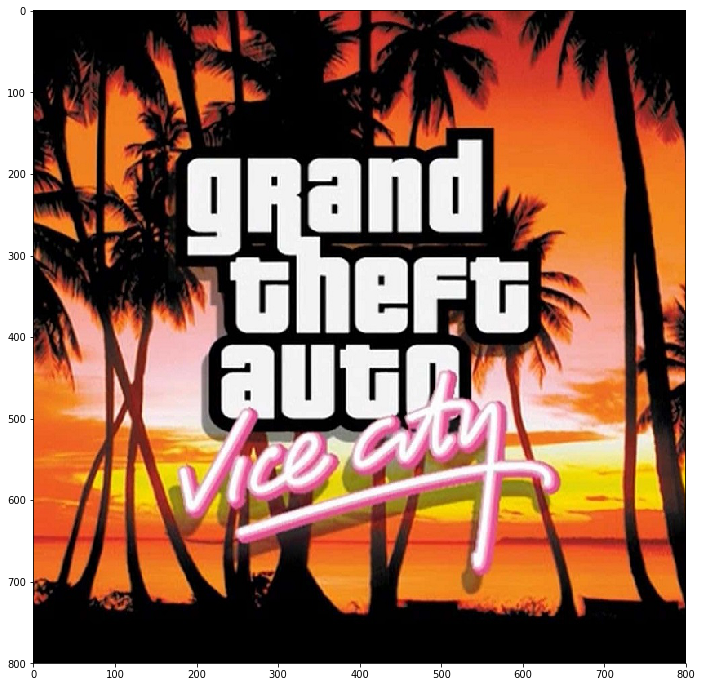

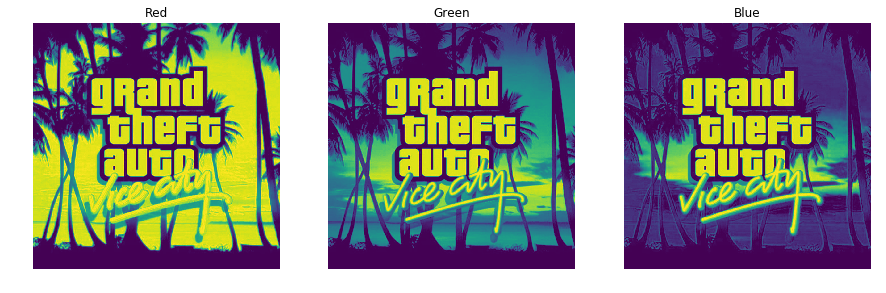

In [21]:
image = ImageAnalyser('gta_800x800.png')
image.show_original_image()
image.display_rgb()

In [26]:
class AnalogTransDemo:
    def __init__(self, data, SNR, verbose=True):
        self.data = data.copy()
        self.SNR = SNR
        
        self.car = None
        self.mod_sig = None
        self.f = None
        self.fs = None
        self.Ts = None
        self.T = None
        self.M = None
        self.n = None
        self.t = None
        self.tp = None
        self.noisy_signal = None
        self.demod_sig = None
        self.rcv_bits = None
        
        self.exdata = []
        self.rcv = []
        
        self.data_shape = None
        self.data_flatten_shape = None
        
        self.initialize_vars()

    def initialize_vars(self):
        self.get_data()
        self.get_misc()
        self.get_carrier()
        self.get_exdata()
        self.get_mod_signal()
        self.get_noisy_signal()
        self.get_demod_signal()
        self.get_recons_signal()
    
    def get_data(self):
        self.data_shape = self.data.shape
        self.data_flatten_shape = self.data.flatten().shape
        self.data = self.data.reshape(self.data_flatten_shape)
        self.data = np.unpackbits(self.data)
        self.data = self.data.astype('int32')
        self.data = self.data * 2 - 1
        
        if self.verbose:
            print('Data augmented')
        
        
    def get_misc(self):
        self.f = 100
        self.fs = self.f * 3
        self.Ts = 1 / self.fs
        self.T = 1 / self.f
        self.M = 1
        self.n = self.M * len(self.data)
        self.t = np.arange(0, self.n * self.T, self.Ts)
        self.tp = np.arange(0, self.T * self.M, self.Ts)
    
    def get_exdata(self):
        if self.verbose:
            print('Flattening data')
        
        for i in range(len(self.data)):
            for _ in range(len(self.tp)):
                self.exdata.append(self.data[i])
        
        if self.verbose:
            print('Data flattened on the carrier')
    
    def get_carrier(self):
        self.car = np.sin(2 * np.pi * self.f * self.t)

        if self.verbose:
            print('Carrier defined')
    
    def plot_car(self):
        fig = plt.figure()
        fig.add_subplot(1, 2, 1)
        plt.plot(self.data[:50])
        fig.add_subplot(1, 2, 2)
        plt.plot(self.car[:50])
    
    def get_mod_signal(self):
        self.mod_sig = self.exdata * self.car
        if self.verbose:
            print('Modulation done')
    
    def plot_mod_sig(self):
#         plt.plot(self.exdata[:100], 'r', linewidth=4)
#         plt.plot(self.car[:100], 'g', linewidth=1)
        plt.plot(self.mod_sig[:100], 'b', linewidth=2)
        plt.show()
    
    def get_noisy_signal(self):
        
        noise = np.random.randn(1, len(self.mod_sig))
        noise_var = .5 * 10 ** (-self.SNR / 10)
        chan_noise = noise * np.sqrt(noise_var)
        self.noisy_signal = chan_noise + self.mod_sig
        self.noisy_signal = self.noisy_signal[0]
        
        if self.verbose:
            print('Noise added')
    
    def plot_noisy_sig(self):
        plt.plot(self.noisy_signal[:100], '-r', linewidth=2)
        plt.show()
    
    def get_demod_signal(self):
        if self.verbose:
            print('Starting demodulation')
        
        self.demod_sig = self.noisy_signal * self.car
        
        k = 0
        for i in range(len(self.data)):
            sm = 0
            for _ in range(len(self.tp)):
                sm += self.demod_sig[k]
                k += 1
            if sm > 0:
                self.rcv.append(1)
            else:
                self.rcv.append(0)
            
            if i != 0 and i % 100000 == 0:
                print(str(i) + ' elements processed')
        if self.verbose:
            print('Demodulation and decoding done')
    
    def plot_demod_sig(self):
        plt.plot(self.demod_sig[:100], '-r', linewidth=2)
        plt.show()

    def get_recons_signal(self):
        self.rcv = np.array(self.rcv)
        self.rcv_bits = self.rcv
        self.rcv = np.packbits(self.rcv)
        self.rcv = self.rcv.reshape(self.data_shape)
        
        if self.verbose:
            print('Image reconstructed')
    
    def get_error_rate(self):
        data = self.data.copy()
        data[data < 0] = 0
        error_rate = np.logical_xor(data, self.rcv_bits)
        error_rate = sum(error_rate)
        return round(error_rate / len(data) * 100, 3)

In [23]:
data = image.rgb

In [24]:
error_rates = []
SNR = [-10, -5, 0, 5, 10]

In [27]:
percentage = 100 / len(SNR)
fig = plt.figure(figsize=(20, 20))
    
for i, j in enumerate(SNR, start = 1):
    signal = AnalogTransDemo(data, j)
    
    a = fig.add_subplot(len(SNR) % 3 + 1, 3, i)
    a.set_title('SNR: {} ({}% error rate)'.format(j, signal.get_error_rate()), fontsize=20)
    a.axis('off')
    img1 = ImageAnalyser.merge_rgb(signal.rcv)
    plt.imshow(img1)
    
    error_rates.append(signal.get_error_rate())
    
    del signal
    
    print('-' * 20)
    print(str(i * percentage) + '%')
    print('-' * 20)
print('Done')

AttributeError: 'AnalogTransDemo' object has no attribute 'verbose'

<Figure size 1440x1440 with 0 Axes>

C:\Users\ThunderBird\Anaconda3\envs\tf\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


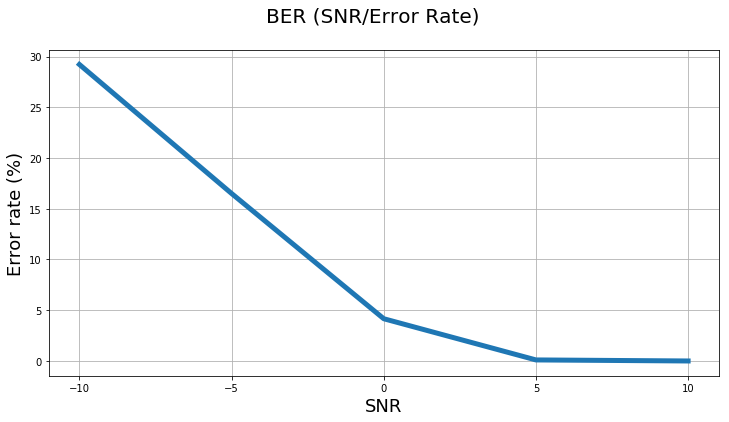

In [8]:
plt.figure(figsize=(12, 6))
plt.suptitle('BER (SNR/Error Rate)', fontsize=20)
plt.xlabel('SNR', fontsize=18)
plt.ylabel('Error rate (%)', fontsize=18)
plt.locator_params(axis='x', nbins=len(SNR))
plt.grid(True)
ax = plt.axes()
ax.plot(SNR, error_rates, linewidth=5)

In [23]:
# signal.plot_car()

In [ ]:
# signal.plot_mod_sig()

In [ ]:
# signal.plot_noisy_sig()

In [ ]:
# signal.plot_demod_sig()